In [1]:
import os
import shutil
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import pandas as pd
import glob
import subprocess
import matplotlib.pyplot as plt

# ==========================================
# 1. MASTER CONFIGURATION
# ==========================================
BASE_DIR = "simulation"

# Sub-folders Updated
DIR_RAW_IMG    = f"{BASE_DIR}/00_raw_images"    # NEW: Source Frames
DIR_INPUT_IMG  = f"{BASE_DIR}/01_input_images"  # Blended Frames (Input to Model)
DIR_INPUT_CSV  = f"{BASE_DIR}/02_input_vectors"
DIR_RTL_OUT    = f"{BASE_DIR}/03_rtl_output"
DIR_PY_IMG     = f"{BASE_DIR}/04_output_python"
DIR_RTL_IMG    = f"{BASE_DIR}/05_output_rtl"

# File Names
CSV_INPUT_FILE = f"{DIR_INPUT_CSV}/test_vector.csv"
CSV_RTL_FILE   = f"{DIR_RTL_OUT}/rtl_out.csv"
TB_FILE        = f"{BASE_DIR}/tb_master.v"

# Model Config
WEIGHTS_DIR    = "model" 
SCALE          = 1024.0 # Q6.10

# Setup Folder Structure
folders = [DIR_RAW_IMG, DIR_INPUT_IMG, DIR_INPUT_CSV, DIR_RTL_OUT, DIR_PY_IMG, DIR_RTL_IMG]
for f in folders:
    os.makedirs(f, exist_ok=True)
    for file in glob.glob(f"{f}/*"):
        os.remove(file)

print(f"✅ Environment Ready. Raw source will be in '{DIR_RAW_IMG}'")

✅ Environment Ready. Raw source will be in 'simulation/00_raw_images'


/home/gswt/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from PIL import Image, ImageSequence

# ==========================================
# CONFIGURATION FOR CELL 2
# ==========================================
GIF_SOURCE_PATH = "input/input.gif" # Path ke file GIF kamu
USE_GIF_SOURCE  = True              # Set True jika ingin pakai GIF, False jika ingin bola sintetis

# ==========================================
# 1. STAGE 1: GENERATE/EXTRACT RAW FRAMES
# ==========================================
raw_frames = []

print("🎨 1. Acquiring Raw Frames...")

# Fungsi Helper: Bola Sintetis (Fallback jika tidak ada GIF)
def create_moving_ball(idx, size=(32,32)):
    img = np.zeros(size, dtype=np.uint8)
    radius = 5
    x = (idx * 8 + 5) % 28  
    y = 16
    cv2.circle(img, (x, y), radius, 255, -1)
    return img

# --- A. Cek Sumber GIF ---
if USE_GIF_SOURCE and os.path.exists(GIF_SOURCE_PATH):
    print(f"   📂 Loading from GIF: {GIF_SOURCE_PATH}")
    try:
        # Buka GIF menggunakan Pillow
        gif = Image.open(GIF_SOURCE_PATH)
        
        # Loop setiap frame dalam GIF
        for i, frame in enumerate(ImageSequence.Iterator(gif)):
            # 1. Convert ke Grayscale (L) & Resize ke 32x32
            frame = frame.convert('L').resize((32, 32), Image.NEAREST)
            
            # 2. Convert ke Numpy Array
            img_np = np.array(frame)
            
            # 3. Simpan ke List & File
            raw_frames.append(img_np)
            cv2.imwrite(f"{DIR_RAW_IMG}/raw_{i:04d}.png", img_np)
            
        print(f"   ✅ Extracted {len(raw_frames)} frames from GIF.")
        
    except Exception as e:
        print(f"   ❌ Error loading GIF: {e}. Switching to synthetic data.")
        raw_frames = [] # Reset jika gagal

# --- B. Fallback ke Data Sintetis ---
if not raw_frames: 
    if USE_GIF_SOURCE: print("   ⚠️ GIF not found or failed. Generating synthetic ball...")
    else: print("   🎨 Generating synthetic moving ball...")
    
    NUM_SYNTHETIC_FRAMES = 5
    for i in range(NUM_SYNTHETIC_FRAMES):
        img = create_moving_ball(i)
        raw_frames.append(img)
        cv2.imwrite(f"{DIR_RAW_IMG}/raw_{i:04d}.png", img)

🎨 1. Acquiring Raw Frames...
   📂 Loading from GIF: input/input.gif
   ✅ Extracted 6 frames from GIF.


In [3]:
# ==========================================
# 2. STAGE 2: BLEND FRAMES & VECTORIZE
# ==========================================
vectors = []
print(f"⚗️ 2. Blending Frames (Temporal Interpolation)...")

# Kita butuh minimal 2 frame untuk blending
if len(raw_frames) < 2:
    print("❌ Error: Not enough frames to blend (Need at least 2).")
else:
    # Loop sampai N-1 karena kita butuh pasangan (i) dan (i+1)
    num_blended = len(raw_frames) - 1
    
    for i in range(num_blended):
        # A. Ambil 2 frame berurutan
        frame_curr = raw_frames[i].astype(np.float32)
        frame_next = raw_frames[i+1].astype(np.float32)
        
        # B. RUMUS BLENDING: (Frame 1 + Frame 2) / 2
        # Ini mensimulasikan input yang "blur" atau transisi antar frame
        img_blend_float = (frame_curr + frame_next) / 2.0
        img_blend = np.clip(img_blend_float, 0, 255).astype(np.uint8)
        
        # C. Save Blended Image (Input AI)
        cv2.imwrite(f"{DIR_INPUT_IMG}/input_{i:04d}.png", img_blend)
        
        # D. Convert to Vector (Q6.10) for RTL
        # Normalize (-1.0 to 1.0)
        norm_float = (img_blend.astype(np.float32) / 127.5) - 1.0
        # Quantize (* 1024)
        fixed_point = np.clip(np.round(norm_float * SCALE), -32768, 32767).astype(np.int32)
        vectors.extend(fixed_point.flatten())

    # Save CSV Final
    np.savetxt(CSV_INPUT_FILE, np.array(vectors), fmt='%d')
    
    print(f"✅ Processing Done!")
    print(f"   Source Frames : {len(raw_frames)} (in {DIR_RAW_IMG})")
    print(f"   Blended Inputs: {num_blended} (in {DIR_INPUT_IMG})")
    print(f"   Saved CSV Path: {CSV_INPUT_FILE}")

⚗️ 2. Blending Frames (Temporal Interpolation)...
✅ Processing Done!
   Source Frames : 6 (in simulation/00_raw_images)
   Blended Inputs: 5 (in simulation/01_input_images)
   Saved CSV Path: simulation/02_input_vectors/test_vector.csv


In [4]:
# ==========================================
# 3. PYTHON REFERENCE (GOLDEN MODEL)
# ==========================================
# Helper functions
def rtl_leaky_relu(x): return F.leaky_relu(x, negative_slope=13.0/64.0)

def rtl_trans_conv_padded(x, w, b, pad):
    B, C, H, W = x.shape
    up = torch.zeros((B, C, H*2, W*2), device=x.device); up[:,:,0::2,0::2] = x
    padded = F.pad(up, pad, mode='constant', value=0)
    return F.conv2d(padded, w, bias=b, padding=0)

class GeneratorV3(torch.nn.Module):
    def __init__(self, w_dir):
        super().__init__()
        self.weights = {}
        layers = [("enc1",3),("enc2",4),("enc3",4),("dec1",4),("dec2",4),("out",3)]
        for name, k in layers:
            try:
                w = pd.read_csv(f"{w_dir}/{name}_weight.csv", header=None).values.flatten().reshape(1,1,k,k)
                b = pd.read_csv(f"{w_dir}/{name}_bias.csv", header=None).values.flatten()
                self.weights[f"{name}_w"] = torch.tensor(w, dtype=torch.float32)
                self.weights[f"{name}_b"] = torch.tensor(b, dtype=torch.float32)
            except: pass

    def forward(self, x):
        w = self.weights
        pad = (2,3,2,3)
        x = rtl_leaky_relu(F.conv2d(x, w["enc1_w"], bias=w["enc1_b"]))
        x = rtl_leaky_relu(F.conv2d(x, w["enc2_w"], bias=w["enc2_b"], stride=2))
        x = rtl_leaky_relu(F.conv2d(x, w["enc3_w"], bias=w["enc3_b"], stride=2))
        x = rtl_leaky_relu(rtl_trans_conv_padded(x, w["dec1_w"], w["dec1_b"], pad))
        x = rtl_leaky_relu(rtl_trans_conv_padded(x, w["dec2_w"], w["dec2_b"], pad))
        return torch.tanh(F.conv2d(x, w["out_w"], bias=w["out_b"]))

print("🐍 Running Python Model on Blended Inputs...")
model = GeneratorV3(WEIGHTS_DIR)

# 1. Load Vector
inp_vec = np.loadtxt(CSV_INPUT_FILE, dtype=np.float32)

# 2. [FIX] Hitung Frame Secara Dinamis
pixels_per_frame = 32 * 32
actual_num_frames = len(inp_vec) // pixels_per_frame

print(f"   Detected {actual_num_frames} frames from CSV.")

# 3. Reshape sesuai jumlah frame yang ditemukan
inp_tensor = torch.tensor(inp_vec.reshape(actual_num_frames, 1, 32, 32) / SCALE)

# 4. Run Model
with torch.no_grad():
    out_tensor = model(inp_tensor)

# 5. Save Images
for i in range(actual_num_frames):
    img = ((out_tensor[i,0].numpy() + 1.0) / 2.0) * 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)
    cv2.imwrite(f"{DIR_PY_IMG}/py_out_{i:04d}.png", img)

print(f"✅ Python outputs saved ({actual_num_frames} frames).")

🐍 Running Python Model on Blended Inputs...
   Detected 5 frames from CSV.
✅ Python outputs saved (5 frames).


In [5]:
# ==========================================
# 4. GENERATE CLEAN TESTBENCH
# ==========================================
# Menggunakan logika Smart Filter (cnt_out < 784)
# Tanpa Debug File intermediate

tb_content = f"""
`timescale 1ns / 1ps

module master_tb;

    parameter DATA_WIDTH = 16;
    
    // PATHS INJECTED FROM PYTHON
    parameter FILE_IN  = "{CSV_INPUT_FILE}";
    parameter FILE_OUT = "{CSV_RTL_FILE}"; 

    parameter PIXELS_PER_FRAME = 32 * 32; // 1024
    parameter TARGET_OUT_PIXELS = 28 * 28; // 784 (V3 Output)

    reg clk, rst_n, valid_in;
    reg signed [DATA_WIDTH-1:0] data_in;
    wire valid_out;
    wire signed [DATA_WIDTH-1:0] data_out;

    integer f_in, f_out, scan_st;
    reg signed [31:0] temp_read;
    integer input_pixel_cnt;
    integer out_pixel_cnt;

    // DUT INSTANTIATION
    generator_v3 #(.DATA_WIDTH(DATA_WIDTH), .TANH_LUT_FILE_PATH("rtl/memory/tanh_lut.mem")) dut (
        .clk(clk), .rst_n(rst_n), .valid_in(valid_in), .data_in(data_in), 
        .valid_out(valid_out), .data_out(data_out)
    );

    initial begin clk = 0; forever #5 clk = ~clk; end

    initial begin
        f_in = $fopen(FILE_IN, "r");
        f_out = $fopen(FILE_OUT, "w");

        if (!f_in) begin $display("Error opening input file"); $finish; end

        // 1. Initial Reset
        rst_n = 0; valid_in = 0; data_in = 0; 
        input_pixel_cnt = 0; out_pixel_cnt = 0;
        #20 rst_n = 1; #20;

        while (!$feof(f_in)) begin
            scan_st = $fscanf(f_in, "%d\\n", temp_read);
            if (scan_st == 1) begin
                @(posedge clk);
                valid_in <= 1;
                data_in  <= temp_read[15:0];
                input_pixel_cnt = input_pixel_cnt + 1;

                // --- END OF FRAME DETECTION ---
                if (input_pixel_cnt == PIXELS_PER_FRAME) begin
                    // A. Stop Input
                    @(posedge clk);
                    valid_in <= 0;
                    
                    // B. Pipeline Drain (Tunggu Flush dari ZeroPad selesai)
                    // Wait time 35000 cycle (sangat aman)
                    repeat(35000) @(posedge clk); 
                    
                    // C. Hardware Reset (Clean State for Next Frame)
                    rst_n <= 0; repeat(100) @(posedge clk); 
                    rst_n <= 1; repeat(100) @(posedge clk);
                    
                    // D. Reset Counters
                    input_pixel_cnt = 0;
                    out_pixel_cnt = 0; // Reset output counter per frame
                end
            end
        end
        
        repeat(5000) @(posedge clk);
        $fclose(f_in); $fclose(f_out);
        $finish;
    end

    // --- SMART OUTPUT FILTER ---
    // Hanya tulis data jika jumlah pixel output belum mencapai target (784).
    // Ini membuang sampah flush (0) yang mungkin keluar di akhir frame.
    always @(posedge clk) begin
        if (valid_out) begin
            if (out_pixel_cnt < TARGET_OUT_PIXELS) begin
                $fwrite(f_out, "%d\\n", data_out);
                out_pixel_cnt = out_pixel_cnt + 1;
            end
        end
    end

endmodule
"""

with open(TB_FILE, "w") as f:
    f.write(tb_content)

print(f"✅ Generated Clean Testbench: {TB_FILE}")

✅ Generated Clean Testbench: simulation/tb_master.v


In [6]:
# ==========================================
# 5. RUN RTL SIMULATION
# ==========================================
print("⚙️ Compiling and Running RTL Simulation...")

# Command: Compile tb_master.v dan semua file di folder rtl/ (termasuk weights)
# Output executable ditaruh di folder simulation
cmd = f"iverilog -o {BASE_DIR}/sim_exec {TB_FILE} rtl/*.v rtl/weights/*.v && vvp {BASE_DIR}/sim_exec"

try:
    # Run command shell
    result = subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print("✅ Simulation Finished Successfully.")
    # print(result.stdout.decode()) # Uncomment jika ingin lihat log simulasi
except subprocess.CalledProcessError as e:
    print("❌ Simulation FAILED!")
    print(e.stderr.decode())

⚙️ Compiling and Running RTL Simulation...
✅ Simulation Finished Successfully.


Displaying 5 comparison frames...


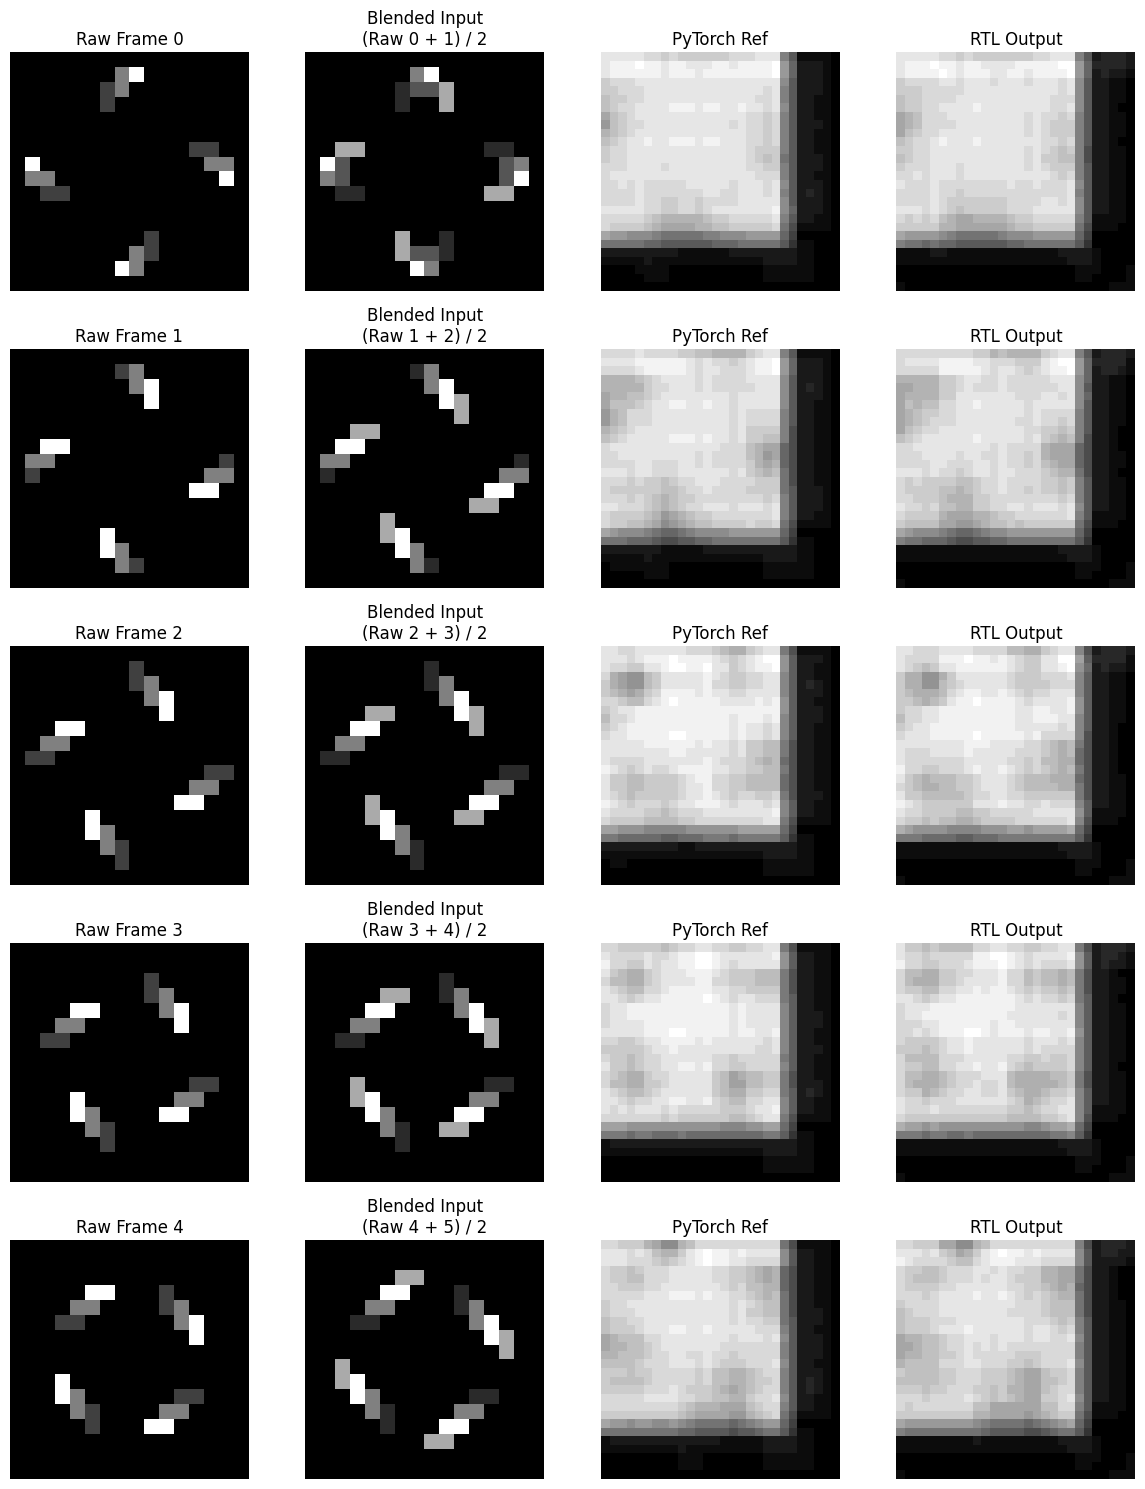

In [7]:
# ==========================================
# 6. VISUAL DASHBOARD (UPDATED)
# ==========================================
if not os.path.exists(CSV_RTL_FILE):
    print("❌ RTL Output CSV not found!")
else:
    # 1. Reconstruct RTL Images
    raw_data = np.loadtxt(CSV_RTL_FILE, dtype=np.int32)
    pixels_per_frame = 28 * 28
    num_frames = len(raw_data) // pixels_per_frame
    
    if num_frames > 0:
        patches = raw_data[:num_frames*pixels_per_frame].reshape(num_frames, 28, 28)
        for i, patch in enumerate(patches):
            img_float = patch.astype(np.float32) / SCALE
            img = ((img_float + 1.0) / 2.0) * 255.0
            img = np.clip(img, 0, 255).astype(np.uint8)
            cv2.imwrite(f"{DIR_RTL_IMG}/rtl_out_{i:04d}.png", img)

    # 2. Visualization
    raw_imgs   = sorted(glob.glob(f"{DIR_RAW_IMG}/*.png"))
    input_imgs = sorted(glob.glob(f"{DIR_INPUT_IMG}/*.png")) # Blended
    rtl_imgs   = sorted(glob.glob(f"{DIR_RTL_IMG}/*.png"))

    n_show = min(len(input_imgs), len(rtl_imgs))
    
    plt.figure(figsize=(12, 3 * n_show))
    
    print(f"Displaying {n_show} comparison frames...")
    
    for i in range(n_show):
        # Column 1: Raw Frames Source (t & t+1)
        plt.subplot(n_show, 4, i*4 + 1)
        # Tampilkan Raw t dan Raw t+1 ditumpuk kecil atau salah satu saja
        # Disini kita tampilkan Raw t saja sebagai referensi asal
        if i < len(raw_imgs):
            plt.imshow(cv2.imread(raw_imgs[i], 0), cmap='gray')
            plt.title(f"Raw Frame {i}")
        plt.axis('off')

        # Column 2: The Blended Input (Real Input)
        plt.subplot(n_show, 4, i*4 + 2)
        plt.imshow(cv2.imread(input_imgs[i], 0), cmap='gray')
        plt.title(f"Blended Input\n(Raw {i} + {i+1}) / 2")
        plt.axis('off')

        # Column 3: Python Output
        plt.subplot(n_show, 4, i*4 + 3)
        # (Load from DIR_PY_IMG logic same as before)
        py_path = f"{DIR_PY_IMG}/py_out_{i:04d}.png"
        if os.path.exists(py_path):
            plt.imshow(cv2.imread(py_path, 0), cmap='gray')
            plt.title("PyTorch Ref")
        plt.axis('off')

        # Column 4: RTL Output
        plt.subplot(n_show, 4, i*4 + 4)
        plt.imshow(cv2.imread(rtl_imgs[i], 0), cmap='gray')
        plt.title("RTL Output")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
import cv2
import glob
import os
import numpy as np

# ==========================================
# 7. GENERATE FINAL INTERLEAVED SEQUENCES
# ==========================================
DIR_FINAL_PY  = f"{BASE_DIR}/06_final_python"
DIR_FINAL_RTL = f"{BASE_DIR}/07_final_rtl"

os.makedirs(DIR_FINAL_PY, exist_ok=True)
os.makedirs(DIR_FINAL_RTL, exist_ok=True)

# --- CONFIG CROP PADDING ---
CROP_BOTTOM = 6
CROP_RIGHT  = 6

def create_sequence(interp_folder, output_folder, label):
    # Bersihkan folder tujuan
    for f in glob.glob(f"{output_folder}/*"): os.remove(f)
    
    # List file
    raw_files    = sorted(glob.glob(f"{DIR_RAW_IMG}/*.png"))
    interp_files = sorted(glob.glob(f"{interp_folder}/*.png"))
    
    n_frames = min(len(raw_files), len(interp_files))
    
    if n_frames == 0:
        print(f"⚠️ {label}: Tidak ada file. Cek step sebelumnya.")
        return

    print(f"🎬 Generating {label} Sequence ({n_frames * 2} frames)...")
    print(f"   ✂️ Cropping Interpolation: Bottom={CROP_BOTTOM}px, Right={CROP_RIGHT}px")
    
    seq_idx = 0
    
    for i in range(n_frames):
        # --- A. FRAME GENAP (RAW IMAGE) ---
        img_raw = cv2.imread(raw_files[i], cv2.IMREAD_GRAYSCALE)
        cv2.imwrite(f"{output_folder}/seq_{seq_idx:04d}_raw.png", img_raw)
        seq_idx += 1
        
        # --- B. FRAME GANJIL (INTERPOLASI) ---
        img_int = cv2.imread(interp_files[i], cv2.IMREAD_GRAYSCALE)
        if img_int is None: continue
            
        # 1. AUTO CONTRAST
        img_norm = cv2.normalize(img_int, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        
        # 2. INVERT COLORS
        img_inverted = 255 - img_norm
        
        # 3. [BARU] CROP PADDING (KANAN BAWAH)
        # Slicing numpy: image[y_start : y_end, x_start : x_end]
        h, w = img_inverted.shape
        # Pastikan tidak crop berlebihan
        crop_h = h - CROP_BOTTOM if CROP_BOTTOM < h else h
        crop_w = w - CROP_RIGHT  if CROP_RIGHT < w  else w
        
        img_cropped = img_inverted[0:crop_h, 0:crop_w]
        
        # 4. RESIZE KE 32x32
        # Resize dari ukuran yang sudah dicrop (misal 26x26) kembali ke 32x32
        img_resized = cv2.resize(img_cropped, (32, 32), interpolation=cv2.INTER_NEAREST)
        
        # Save
        cv2.imwrite(f"{output_folder}/seq_{seq_idx:04d}_interp.png", img_resized)
        seq_idx += 1

    # Frame Penutup
    if len(raw_files) > n_frames:
        img_last = cv2.imread(raw_files[n_frames], cv2.IMREAD_GRAYSCALE)
        cv2.imwrite(f"{output_folder}/seq_{seq_idx:04d}_raw.png", img_last)
    
    print(f"✅ Saved to: {output_folder}")

# --- EXECUTE ---
create_sequence(DIR_PY_IMG, DIR_FINAL_PY, "Python")
create_sequence(DIR_RTL_IMG, DIR_FINAL_RTL, "RTL")

🎬 Generating Python Sequence (10 frames)...
   ✂️ Cropping Interpolation: Bottom=6px, Right=6px
✅ Saved to: simulation/06_final_python
🎬 Generating RTL Sequence (10 frames)...
   ✂️ Cropping Interpolation: Bottom=6px, Right=6px
✅ Saved to: simulation/07_final_rtl


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
import os
import cv2

# ==============================================================================
# 8. FINAL VERIFICATION (COMPACT GRID STYLE)
# ==============================================================================
RTL_CSV_PATH = CSV_RTL_FILE
INP_CSV_PATH = CSV_INPUT_FILE
WEIGHTS_PATH = WEIGHTS_DIR
SAVE_PATH    = f"{BASE_DIR}/verification_summary_final.png"

# Config
IMG_H, IMG_W = 28, 28
SCALE_Q610   = 1024.0
CROP_B, CROP_R = 2, 2  # Crop Padding

# ---------------------------------------------------------
# A. Model Definition & Helpers
# ---------------------------------------------------------
def rtl_leaky_relu(x): return F.leaky_relu(x, negative_slope=13.0/64.0)

def rtl_trans_conv_padded(x, w, b, pad_cfg):
    B, C, H, W = x.shape
    up = torch.zeros((B, C, H*2, W*2), device=x.device); up[:,:,0::2,0::2] = x
    padded = F.pad(up, pad_cfg, mode='constant', value=0)
    return F.conv2d(padded, w, bias=b, padding=0)

class GeneratorV3_Verify(torch.nn.Module):
    def __init__(self, w_dir):
        super().__init__()
        self.weights = {}
        self.pad = (2,3,2,3)
        for name, k in [("enc1",3),("enc2",4),("enc3",4),("dec1",4),("dec2",4),("out",3)]:
            try:
                w = pd.read_csv(f"{w_dir}/{name}_weight.csv", header=None).values.flatten().reshape(1,1,k,k)
                b = pd.read_csv(f"{w_dir}/{name}_bias.csv", header=None).values.flatten()
                self.weights[f"{name}_w"] = torch.tensor(w, dtype=torch.float32)
                self.weights[f"{name}_b"] = torch.tensor(b, dtype=torch.float32)
            except: pass

    def forward(self, x):
        w = self.weights
        x = rtl_leaky_relu(F.conv2d(x, w["enc1_w"], bias=w["enc1_b"]))
        x = rtl_leaky_relu(F.conv2d(x, w["enc2_w"], bias=w["enc2_b"], stride=2))
        x = rtl_leaky_relu(F.conv2d(x, w["enc3_w"], bias=w["enc3_b"], stride=2))
        x = rtl_leaky_relu(rtl_trans_conv_padded(x, w["dec1_w"], w["dec1_b"], self.pad))
        x = rtl_leaky_relu(rtl_trans_conv_padded(x, w["dec2_w"], w["dec2_b"], self.pad))
        return torch.tanh(F.conv2d(x, w["out_w"], bias=w["out_b"]))

def get_math_data(data_int_q610, crop=True):
    f = data_int_q610.astype(np.float32) / SCALE_Q610
    img_u8 = np.clip(((f + 1.0) / 2.0) * 255.0, 0, 255).astype(np.uint8)
    if crop:
        h, w = img_u8.shape
        img_u8 = img_u8[0:h-CROP_B, 0:w-CROP_R]
    return img_u8

def get_visual_data(data_int_q610, crop=True):
    img_u8 = get_math_data(data_int_q610, crop)
    img_vis = cv2.normalize(img_u8, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return 255 - img_vis

# ---------------------------------------------------------
# C. Execution & Plotting
# ---------------------------------------------------------
print("📊 Generating Compact Verification Plot...")

if not os.path.exists(RTL_CSV_PATH): print("❌ RTL Output missing."); exit()

# Load Data
rtl_raw = np.loadtxt(RTL_CSV_PATH, dtype=np.int32)
num_frames = len(rtl_raw) // (IMG_H * IMG_W)
rtl_data = rtl_raw[:num_frames*IMG_H*IMG_W].reshape(num_frames, IMG_H, IMG_W)

# Run Software
model = GeneratorV3_Verify(WEIGHTS_PATH)
inp_vec = np.loadtxt(INP_CSV_PATH, dtype=np.float32)
inp_vec = inp_vec[:num_frames * 32 * 32]
inp_tensor = torch.tensor(inp_vec.reshape(num_frames, 1, 32, 32) / SCALE_Q610)
with torch.no_grad(): sw_out_float = model(inp_tensor).squeeze().numpy()
sw_data_int = np.clip(np.round(sw_out_float * SCALE_Q610), -32768, 32767).astype(np.int32)

# --- PLOTTING CONFIG ---
# wspace=0.05 (Rapat Kiri-Kanan), hspace=0.1 (Rapat Atas-Bawah)
fig, axes = plt.subplots(num_frames, 4, figsize=(16, 3 * num_frames), 
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.15})
if num_frames == 1: axes = [axes]

print("\n   [Frame] | MSE  | MaxDiff | Status")
print("   " + "-"*40)

for i in range(num_frames):
    # Data Process
    math_sw  = get_math_data(sw_data_int[i], crop=True)
    math_rtl = get_math_data(rtl_data[i],    crop=True)
    diff_map = np.abs(math_sw.astype(np.int16) - math_rtl.astype(np.int16)).astype(np.uint8)
    
    mse_val  = np.mean(diff_map.astype(np.float32)**2)
    max_diff = np.max(diff_map)
    
    status = "✅ OK" if max_diff <= 5 else "⚠️ CHECK"
    print(f"   Frame {i} | {mse_val:5.2f}| {max_diff:5d}   | {status}")

    # Visuals
    vis_input = cv2.normalize(inp_vec.reshape(num_frames, 32, 32)[i], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    vis_sw    = get_visual_data(sw_data_int[i], crop=True)
    vis_rtl   = get_visual_data(rtl_data[i],    crop=True)

    # --- PLOT ROW ---
    # 1. Input
    ax1 = axes[i][0] if num_frames > 1 else axes[0]
    ax1.imshow(vis_input, cmap='gray')
    ax1.set_ylabel(f"Frame {i}", fontsize=12, fontweight='bold') # Label Frame di Kiri
    ax1.set_xticks([]); ax1.set_yticks([]) # Hilangkan angka axis

    # 2. Software
    ax2 = axes[i][1] if num_frames > 1 else axes[1]
    ax2.imshow(vis_sw, cmap='gray', vmin=0, vmax=255)
    ax2.set_xticks([]); ax2.set_yticks([])

    # 3. Hardware
    ax3 = axes[i][2] if num_frames > 1 else axes[2]
    ax3.imshow(vis_rtl, cmap='gray', vmin=0, vmax=255)
    ax3.set_xticks([]); ax3.set_yticks([])

    # 4. Heatmap
    ax4 = axes[i][3] if num_frames > 1 else axes[3]
    im = ax4.imshow(diff_map, cmap='gist_heat', vmin=0, vmax=10)
    ax4.set_xticks([]); ax4.set_yticks([])
    
    # Label Error di bawah gambar heatmap (Bukan Title, biar rapi)
    ax4.set_xlabel(f"MSE: {mse_val:.2f} | Max: {max_diff}", fontsize=9, fontweight='bold', color='#aa0000')

    # TITLE HANYA DI BARIS PERTAMA (Biar Rapi)
    if i == 0:
        ax1.set_title("Network Input\n(32x32)", fontsize=12, fontweight='bold', pad=10)
        ax2.set_title("Software Model\n(Inverted)", fontsize=12, fontweight='bold', color='blue', pad=10)
        ax3.set_title("Hardware Output\n(RTL Simulation)", fontsize=12, fontweight='bold', color='green', pad=10)
        ax4.set_title("Pixel Difference\n(Heatmap)", fontsize=12, fontweight='bold', color='red', pad=10)

plt.savefig(SAVE_PATH, bbox_inches='tight', dpi=300)
plt.show()

print(f"\n✅ Compact Plot saved to: {SAVE_PATH}")

📊 Generating Compact Verification Plot...


NameError: name 'pad' is not defined